<h1 align=center><font size = 5>Attention Map </h1 >


<h3>Objective for this Notebook</h3>
<h5> 1. 了解Attention Map如何操作</h5>

In [17]:
from transformers import ViTForImageClassification, ViTModel, ViTImageProcessor
import torch, numpy as np, cv2
from PIL import Image
import matplotlib.pyplot as plt

# 圖片預處理
image = Image.open("image.jpg").convert("RGB").resize((224, 224))
img_np = np.array(image).astype(np.float32) / 255.0

# 處理器
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
inputs = processor(images=image, return_tensors="pt")

# 預測用分類模型
clf_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224").eval()
logits = clf_model(**inputs).logits
class_idx = logits.argmax().item()
print("Top-1 class index:", class_idx)

# 用於 Attention 的模型（要 output_attentions）
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224", output_attentions=True).eval()
outputs = vit_model(**inputs)
attentions = outputs.attentions  # list of [1, heads, tokens, tokens]


Top-1 class index: 281


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


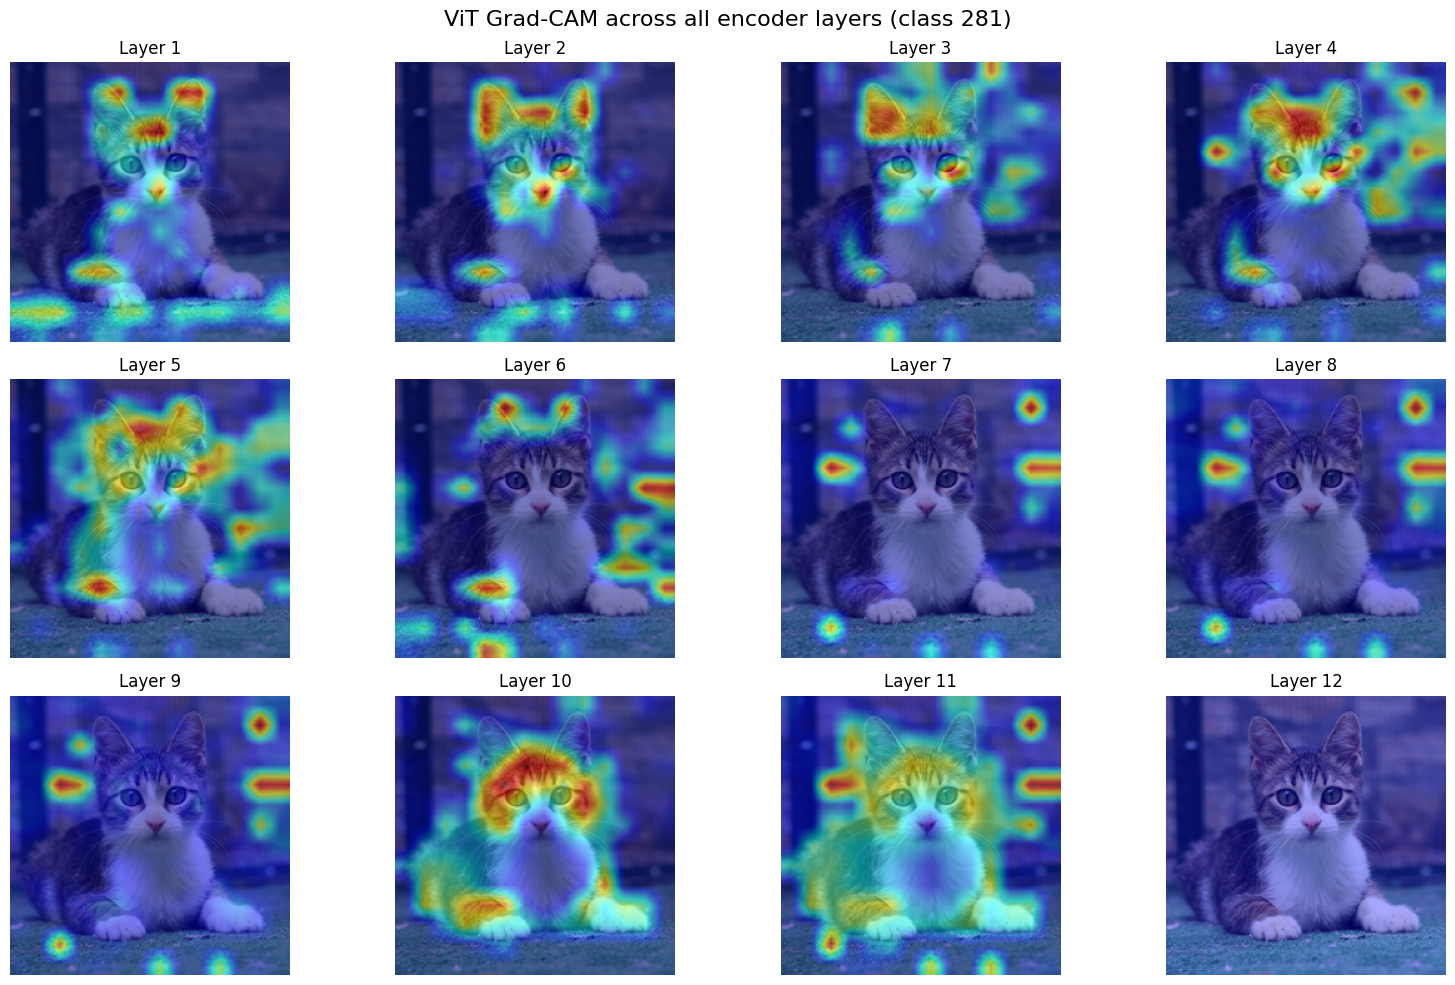

In [25]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import torch.nn as nn

# 1. 包裝模型（回傳 logits）
class ViTWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x).logits

# 2. reshape_transform 讓 ViT 的 patch token 輸出變成 2D 特徵圖
def reshape_transform(tensor, h=14, w=14):
    tensor = tensor[:, 1:, :]  # 去掉 CLS
    B, N, C = tensor.shape
    return tensor.reshape(B, h, w, C).permute(0, 3, 1, 2)

# 3. 包裝模型 & 預測類別
wrapped_model = ViTWrapper(clf_model)
input_tensor = preprocess_image(img_np, mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
class_idx = logits.argmax().item()
targets = [ClassifierOutputTarget(class_idx)]

# 4. 遍歷每一層，計算 Grad-CAM
fig, axs = plt.subplots(3, 4, figsize=(16, 10))
for i in range(12):
    target_layer = [wrapped_model.model.vit.encoder.layer[i].output]
    cam = GradCAM(model=wrapped_model,
                  target_layers=target_layer,
                  reshape_transform=reshape_transform)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    cam_img = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

    ax = axs[i // 4, i % 4]
    ax.imshow(cam_img)
    ax.set_title(f"Layer {i+1}")
    ax.axis("off")

plt.suptitle(f"ViT Grad-CAM across all encoder layers (class {class_idx})", fontsize=16)
plt.tight_layout()
plt.show()


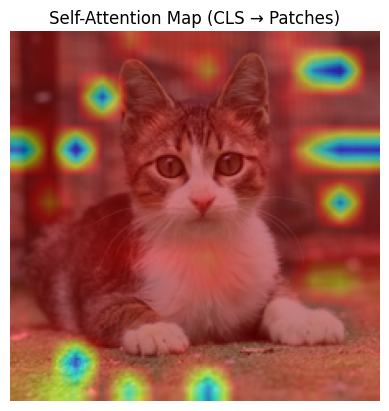

In [20]:
attn_map = attentions[-1][0].mean(dim=0)  # average over heads
cls_attn = attn_map[0, 1:].reshape(14, 14).detach().numpy()
cls_attn = (cls_attn - cls_attn.min()) / (cls_attn.max() - cls_attn.min())
cls_attn = cv2.resize(cls_attn, (224, 224))

heatmap = cv2.applyColorMap(np.uint8(255 * cls_attn), cv2.COLORMAP_JET)
overlay = np.clip((heatmap / 255.0 + img_np) / 2, 0, 1)

plt.imshow(overlay)
plt.title("Self-Attention Map (CLS → Patches)")
plt.axis("off")
plt.show()


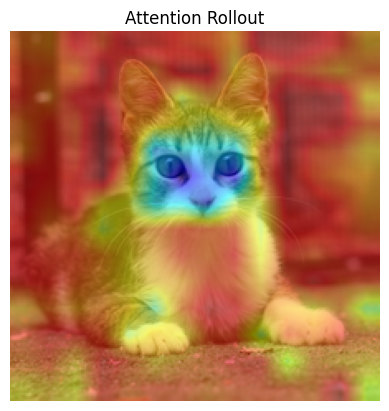

In [21]:
attn_mat = [a.mean(dim=1)[0] for a in attentions]  # average over heads
attn_mat = [a + torch.eye(a.size(-1)) for a in attn_mat]
attn_mat = [a / a.sum(dim=-1, keepdim=True) for a in attn_mat]

joint_attn = attn_mat[0]
for a in attn_mat[1:]:
    joint_attn = a @ joint_attn

rollout = joint_attn[0, 1:].reshape(14, 14).detach().numpy()
rollout = (rollout - rollout.min()) / (rollout.max() - rollout.min())
rollout = cv2.resize(rollout, (224, 224))

heatmap = cv2.applyColorMap(np.uint8(255 * rollout), cv2.COLORMAP_JET)
overlay = np.clip((heatmap / 255.0 + img_np) / 2, 0, 1)

plt.imshow(overlay)
plt.title("Attention Rollout")
plt.axis("off")
plt.show()


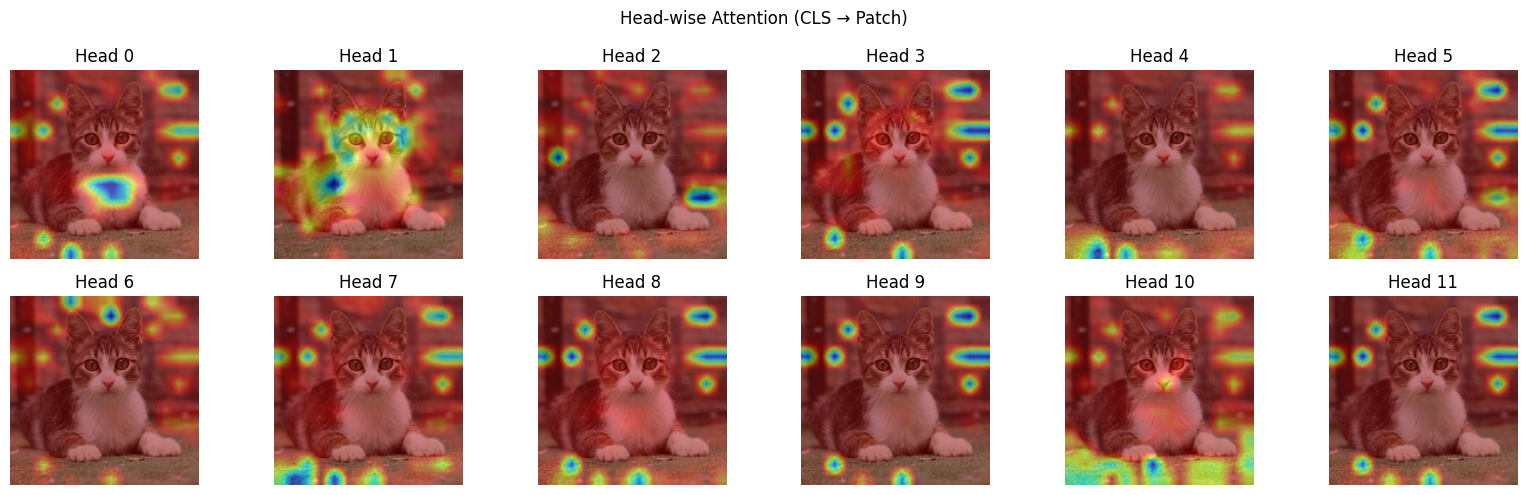

In [22]:
head_attn = attentions[-1][0][:, 0, 1:]  # shape: [heads, 196]
head_attn = head_attn.reshape(head_attn.shape[0], 14, 14).detach().numpy()

fig, axs = plt.subplots(2, 6, figsize=(16, 5))
for i in range(12):
    attn = head_attn[i]
    attn = (attn - attn.min()) / (attn.max() - attn.min())
    attn = cv2.resize(attn, (224, 224))
    overlay = np.clip((cv2.applyColorMap(np.uint8(255 * attn), cv2.COLORMAP_JET) / 255.0 + img_np) / 2, 0, 1)

    ax = axs[i // 6, i % 6]
    ax.imshow(overlay)
    ax.set_title(f"Head {i}")
    ax.axis("off")

plt.suptitle("Head-wise Attention (CLS → Patch)")
plt.tight_layout()
plt.show()
